In [21]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import CDKMRippleCarryAdder, ZGate, PhaseGate, QFTGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import pi, sqrt
import numpy as np
from qiskit.circuit.library import IntegerComparator
import random

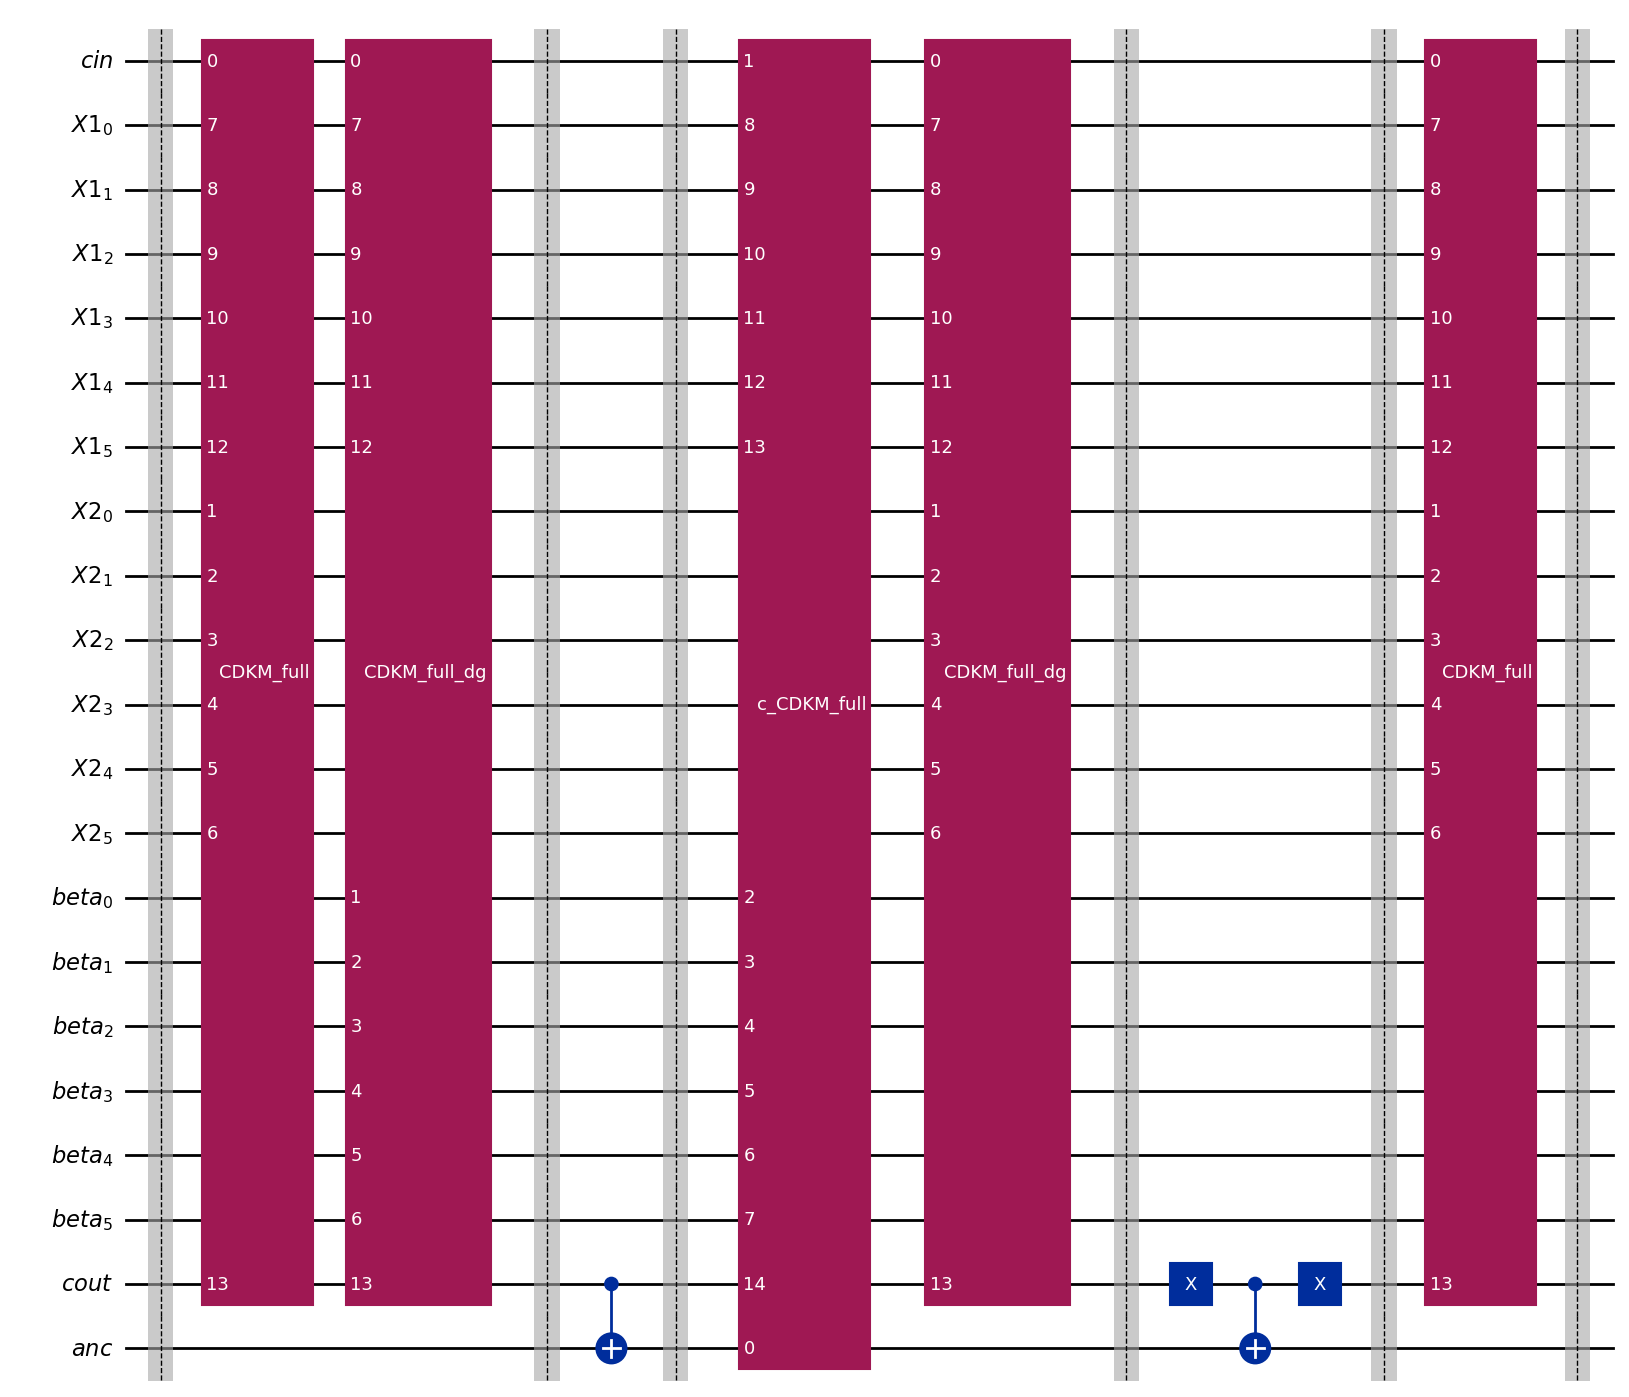

In [22]:
def cuccaro_adder_mod(n_bits):
    x1        = QuantumRegister(n_bits, 'X1')         # alvo x1
    x2        = QuantumRegister(n_bits, 'X2')         # x2 equivalente a x1
    reg_cin   = QuantumRegister(1, 'cin')             # carry-in
    reg_cout  = QuantumRegister(1, 'cout')            # carry-out para operações sobre x
    beta      = QuantumRegister(n_bits, 'beta')       # registrador preparado em |beta>
    anc       = QuantumRegister(1, 'anc')             # ancilla
        
    qc = QuantumCircuit(reg_cin, x1, x2, beta, reg_cout, anc, name = "cuccaro_adder_mod")
    
    adder_full = CDKMRippleCarryAdder(n_bits, kind='full', name='CDKM_full')
    adder_full_ctrl = adder_full.control(1)
    
    qc.barrier()
    qc.append(adder_full, reg_cin[:] + x2[:] + x1[:] + reg_cout[:])
    qc.append(adder_full.inverse(), reg_cin[:] + beta[:] + x1[:] + reg_cout[:])
    qc.barrier()
    qc.cx(reg_cout[0], anc[0])
    qc.barrier()
    qc.append(adder_full_ctrl, anc[:] + reg_cin[:] + beta[:] + x1[:] + reg_cout[:])
    qc.append(adder_full.inverse(), reg_cin[:] + x2[:] + x1[:] + reg_cout[:])

    qc.barrier()
    qc.x(reg_cout[0])
    qc.cx(reg_cout[0], anc[0])
    qc.x(reg_cout[0])
    qc.barrier()
    qc.append(adder_full, reg_cin[:] + x2[:] + x1[:] + reg_cout[:])
    qc.barrier()

    return qc

qc = cuccaro_adder_mod(6)
qc.draw("mpl")

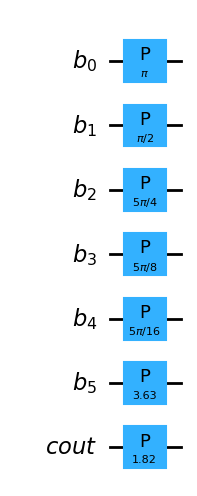

In [23]:
def draper_adder(n_bits, a):
    reg_b = QuantumRegister(n_bits, "b")
    reg_cout = QuantumRegister(1, "cout")

    bitstring = bin(a)[2:].zfill(n_bits)
    bitstring = bitstring[::-1]

    qc = QuantumCircuit(reg_b, reg_cout, name="draper_adder")
    l = [0]*(n_bits)
    cout = [0]
    for j in range(n_bits):
        for k in range(n_bits - j):
            if bitstring[j] == "1":
                lam = np.pi / (2**k)
                l[j + k] += lam

    for j in range(n_bits):
        if bitstring[n_bits - j - 1] == "1":
            lam = np.pi / (2 ** (j + 1))
            cout[0] += lam

    for i in range(len(l)):
        if l[i] != 0:
            qc.p(l[i], reg_b[i])

    for i in range(len(cout)):
        if cout[i] != 0:
            qc.p(cout[0], reg_cout[0])

    return qc

qc = draper_adder(6, 37)
qc.draw("mpl")

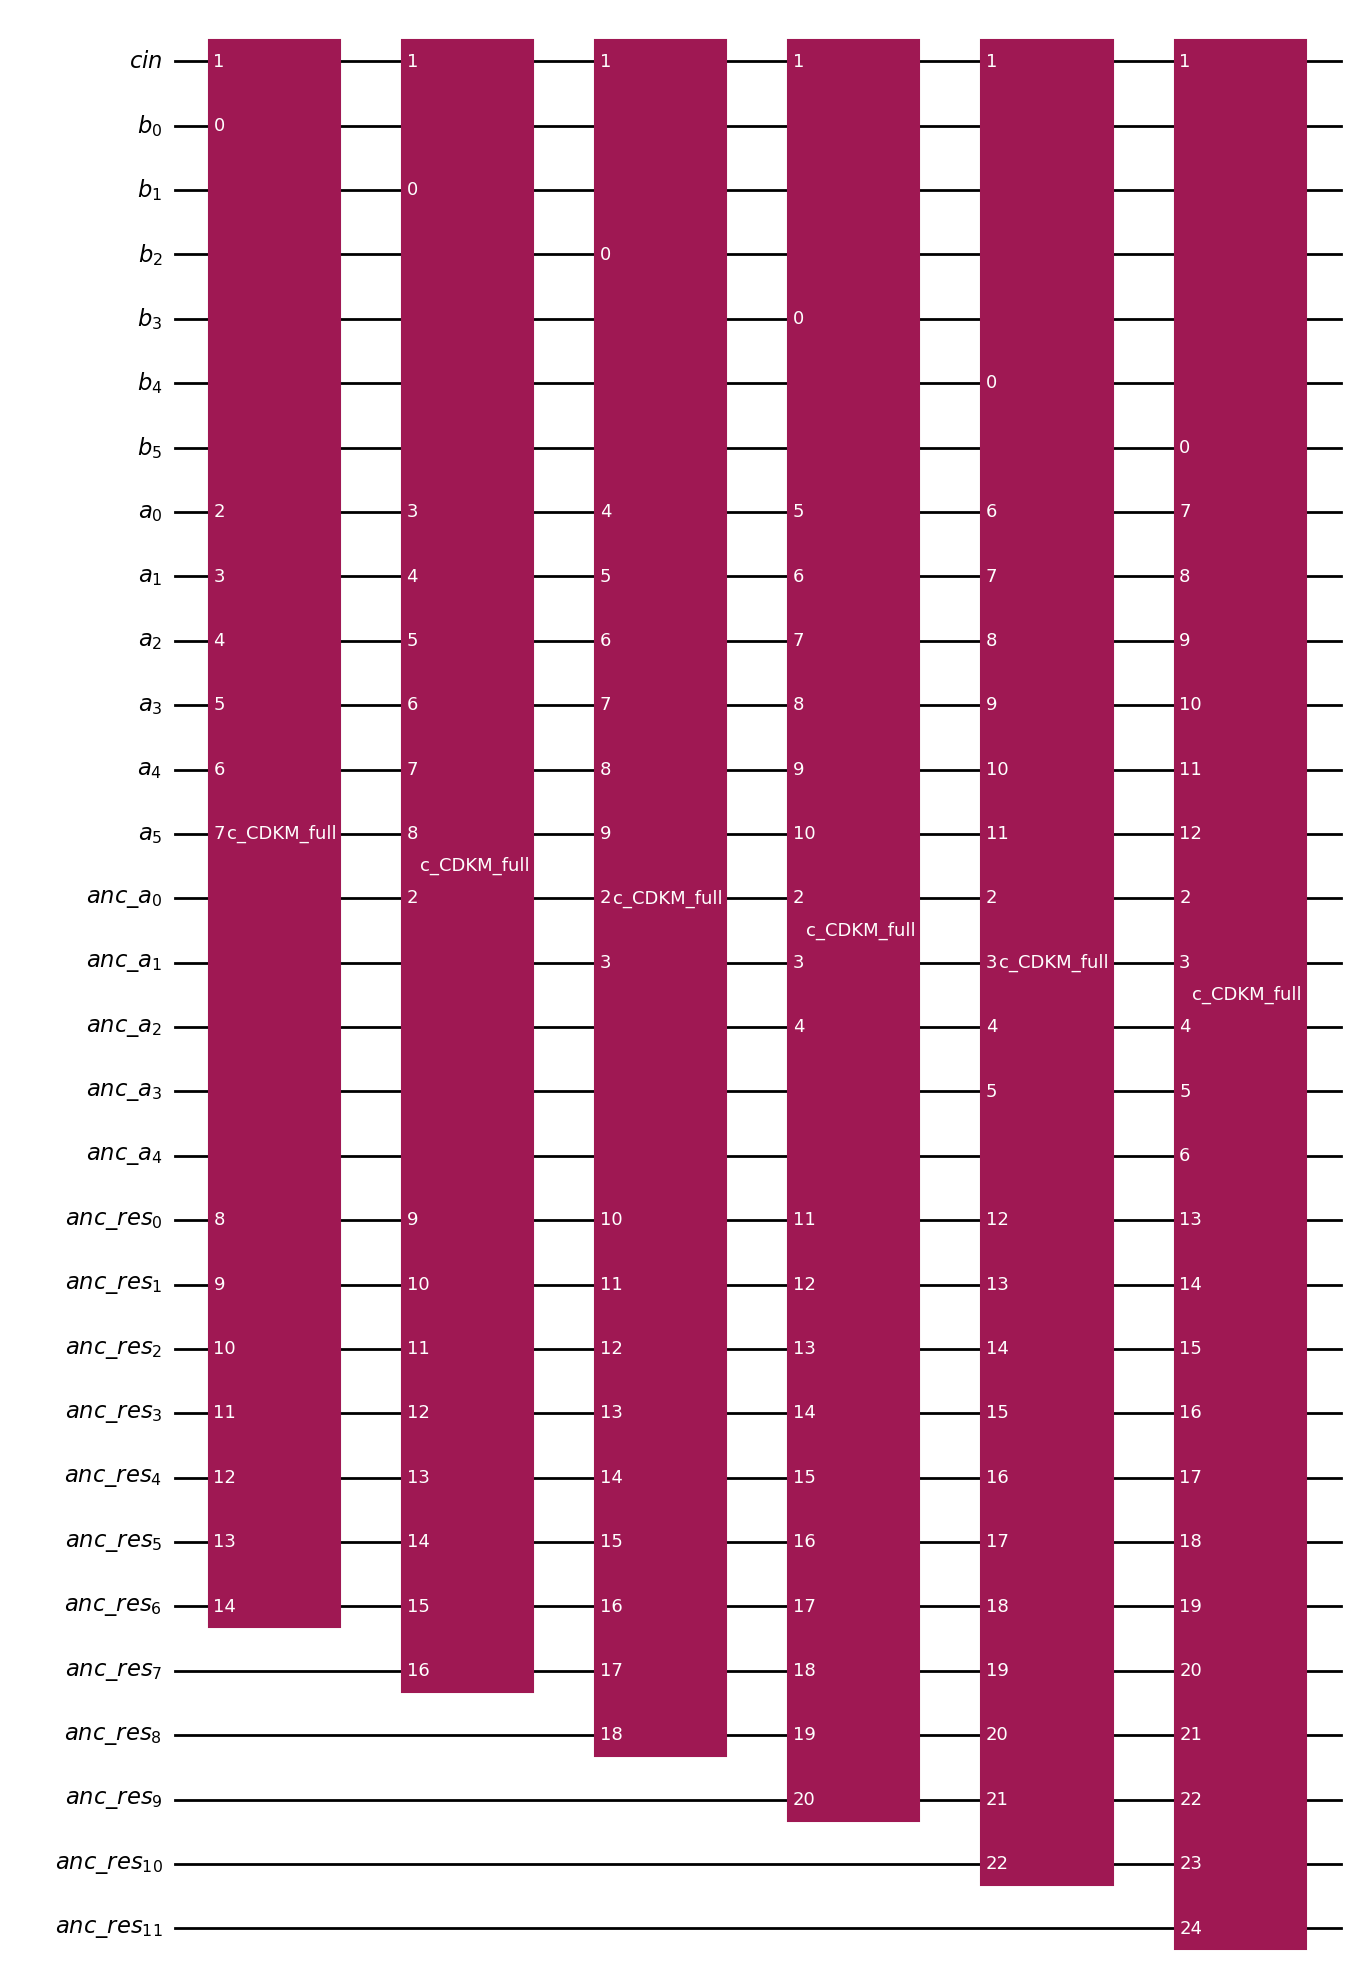

In [24]:
def mult1(n_bits):
    b = QuantumRegister(n_bits, 'b')
    a = QuantumRegister(n_bits, 'a')
    anc_a = QuantumRegister(n_bits - 1, "anc_a")
    anc_res = QuantumRegister(2 * n_bits, "anc_res")
    
    reg_cin   = QuantumRegister(1, 'cin')   
    
    qc = QuantumCircuit(reg_cin ,b, a, anc_a, anc_res, name = "mult1")
    
    for i in range(n_bits):
        adder_full = CDKMRippleCarryAdder(n_bits + i, kind='full', name='CDKM_full')
        adder_full_ctrl = adder_full.control(1)
        qc.append(adder_full_ctrl, b[i:i+1] + reg_cin[:] + anc_a[:i] + a[:] + anc_res[:n_bits+i + 1])
    
    return qc

qc = mult1(6)
qc.draw("mpl")

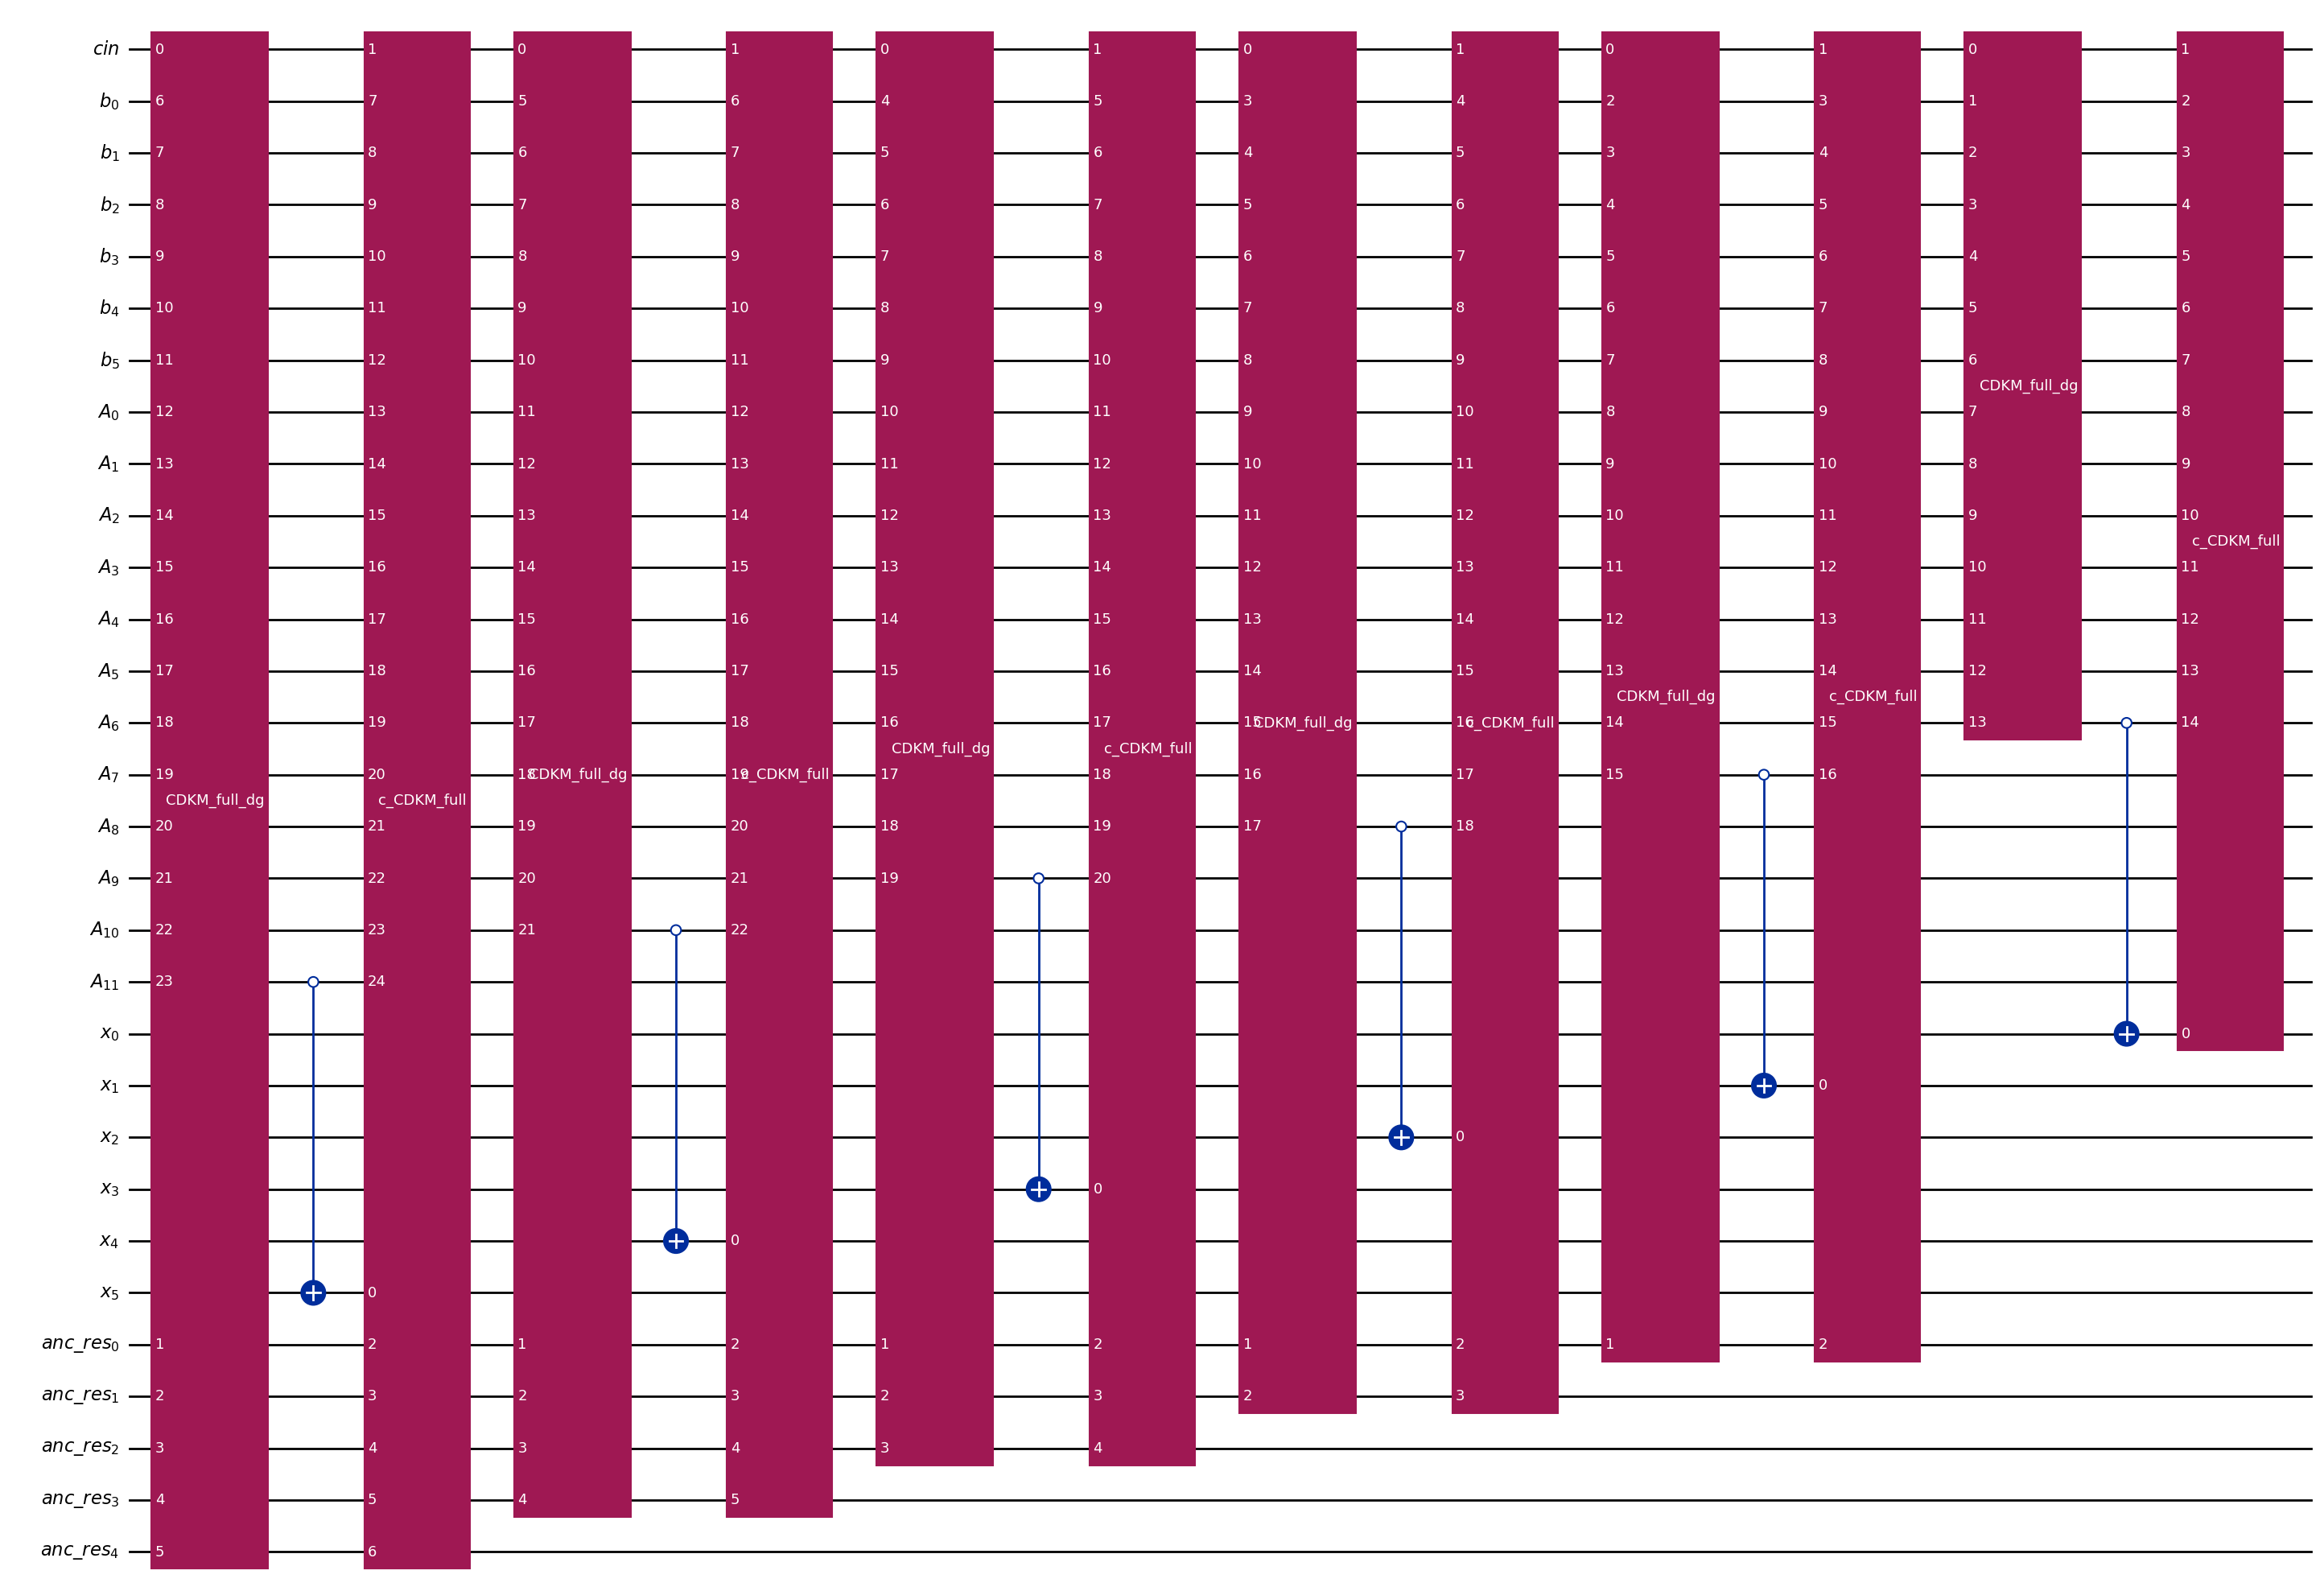

In [25]:
def div(n_bits):
    b = QuantumRegister(n_bits, 'b')
    a = QuantumRegister(2 * n_bits, 'A')
    x = QuantumRegister(n_bits, "x")
    anc_res = QuantumRegister(n_bits - 1, "anc_res")
    
    reg_cin   = QuantumRegister(1, 'cin')
    
    qc = QuantumCircuit(reg_cin, b, a, x, anc_res, name = "div")

    for i in range(n_bits):
        adder_full = CDKMRippleCarryAdder(2 * n_bits - i - 1, kind='full', name='CDKM_full')
        adder_full_ctrl = adder_full.control(1, ctrl_state='0')
        qc.append(adder_full.inverse(), reg_cin[:] + anc_res[:n_bits - i - 1] + b[:] + a[:2 * n_bits - i])
        qc.cx(a[2 * n_bits - i - 1 : 2 * n_bits - i], x[n_bits - i - 1: n_bits - i], ctrl_state='0')
        qc.append(adder_full_ctrl, x[n_bits - i - 1 : n_bits - i] + reg_cin[:] + anc_res[:n_bits - i - 1] + b[:] + a[:2 * n_bits - i])
    
    return qc

qc = div(6)
qc.draw("mpl", fold=-1)

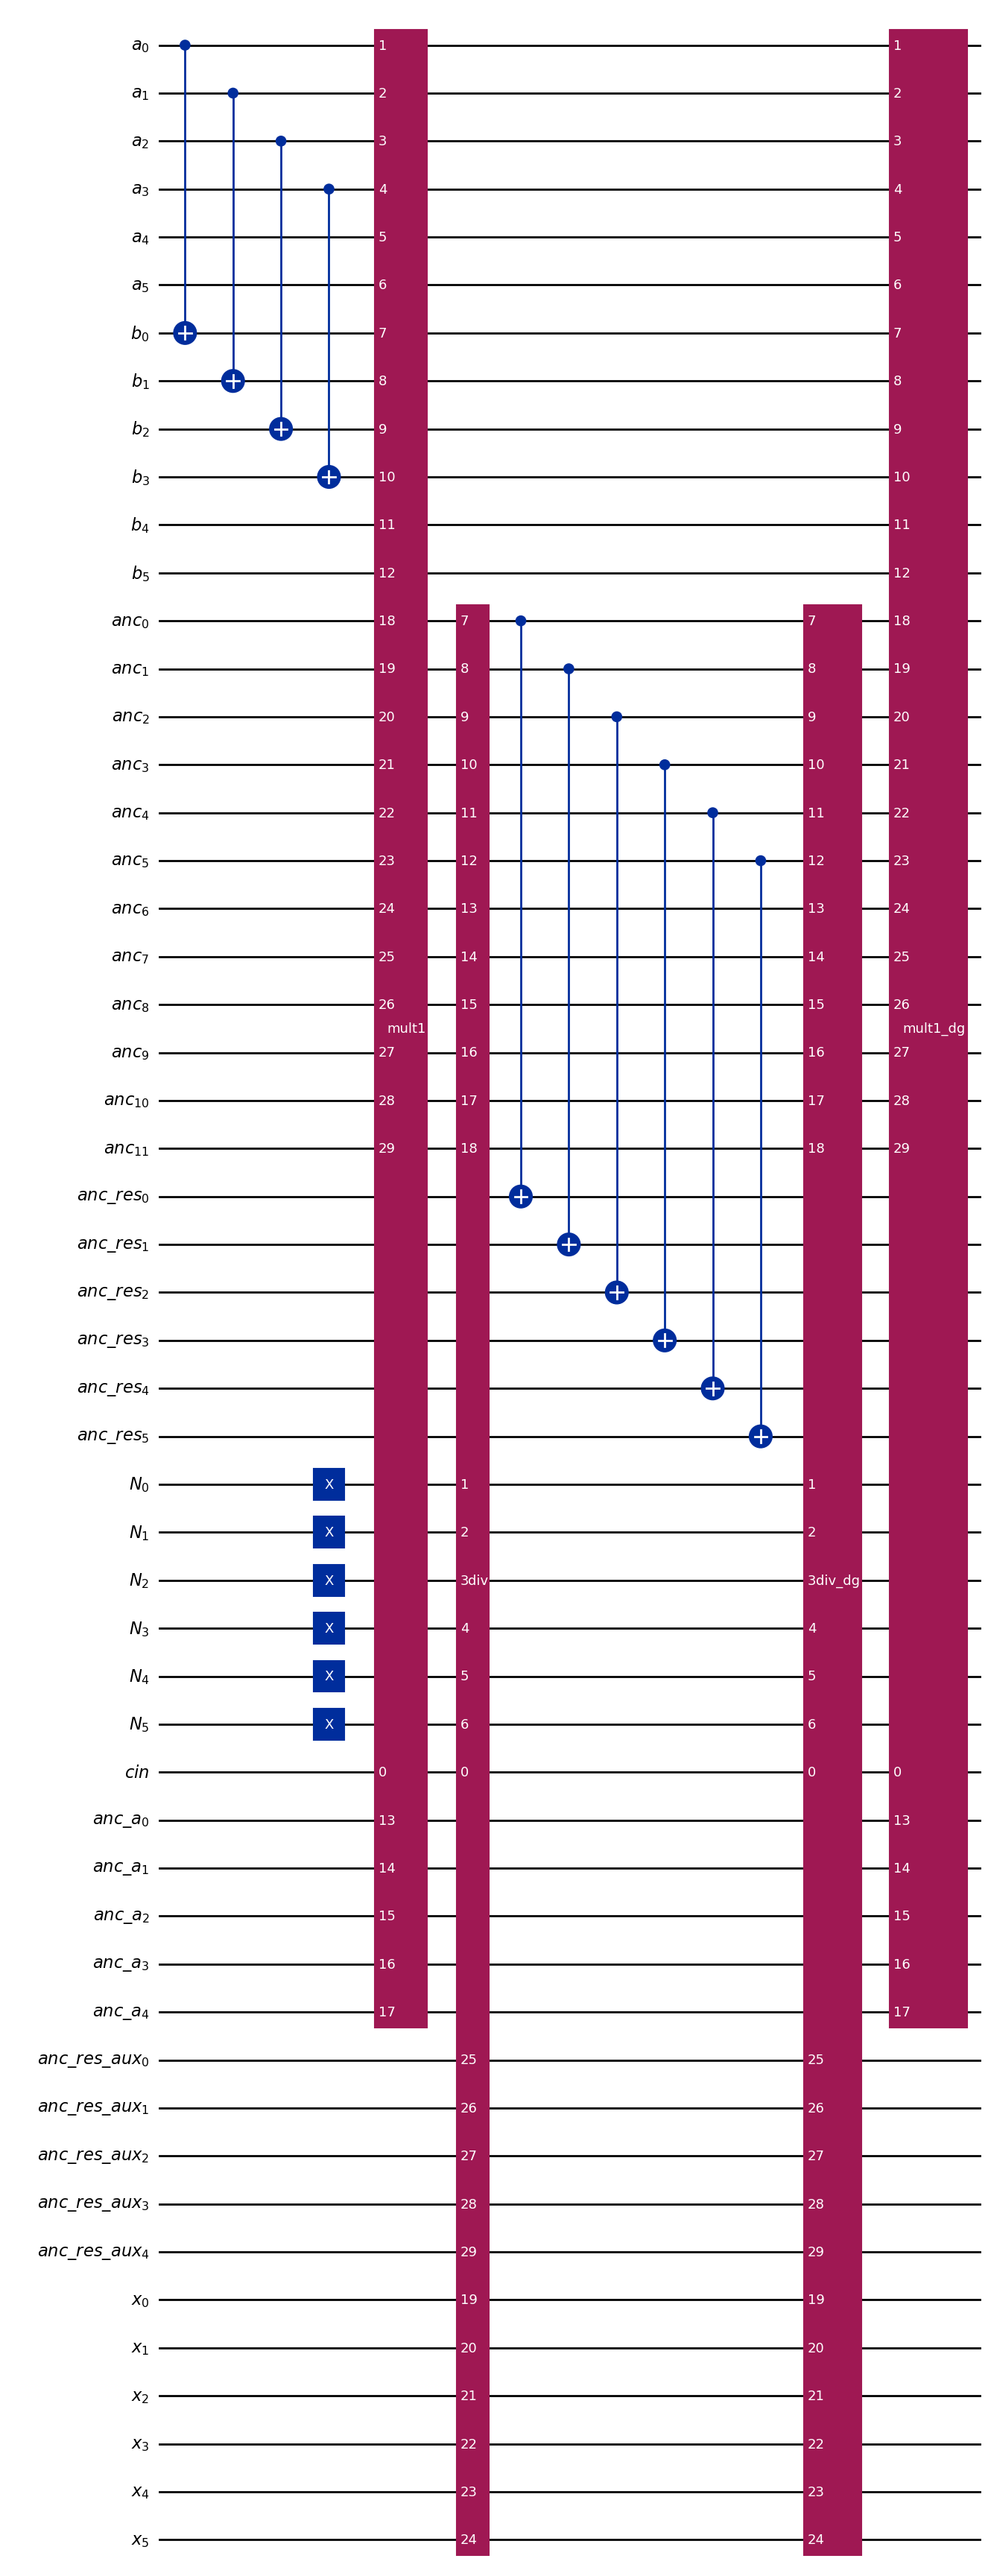

In [26]:
def mult_mod1(n_bits):
    a = QuantumRegister(n_bits, "a")
    b = QuantumRegister(n_bits, "b")
    anc = QuantumRegister(2 * n_bits, "anc")
    anc_a = QuantumRegister(n_bits-1, "anc_a")
    anc_res = QuantumRegister(n_bits, "anc_res")
    
    N = QuantumRegister(n_bits, "N")
    anc_res_aux = QuantumRegister(n_bits - 1, "anc_res_aux")
    x = QuantumRegister(n_bits, "x")
    
    reg_cin = QuantumRegister(1, 'cin')
    
    qc = QuantumCircuit(a, b, anc, anc_res, N, reg_cin, anc_a, anc_res_aux, x, name = "mult_mod1")
    
    for i in range(n_bits-2):
        qc.cx(a[i], b[i])
    
    qc.x(N)
  
    qc.append(mult1(n_bits), reg_cin[:] + a[:] + b[:] + anc_a[:] + anc[:])
    qc.append(div(n_bits), reg_cin[:] + N[:] + anc[:] + x[:] + anc_res_aux[:])
    for i in range(n_bits):
        qc.cx(anc[i], anc_res[i])
    
    qc.append(div(n_bits).inverse(), reg_cin[:] + N[:] + anc[:] + x[:] + anc_res_aux[:])
    qc.append(mult1(n_bits).inverse(), reg_cin[:] + a[:] + b[:] + anc_a[:] + anc[:])
    
    return qc

qc = mult_mod1(6)
qc.draw("mpl")

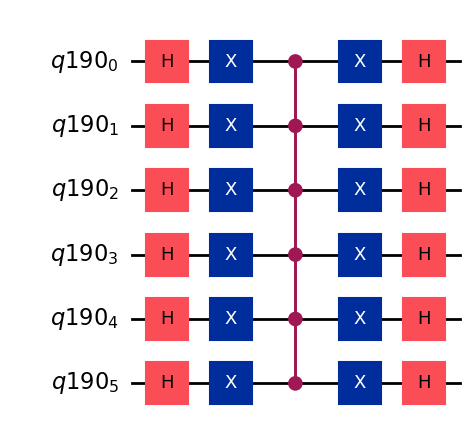

In [27]:
def inversaoSobreMedia(n_bits, controlado=False):
  q_reg = QuantumRegister(n_bits)

  if controlado:
    c_reg = QuantumRegister(1)

    qc = QuantumCircuit(c_reg, q_reg, name="C-inv-media")

    qc.ch(c_reg[0], q_reg)
    qc.cx(c_reg[0], q_reg)
    qc.append(ZGate().control(num_ctrl_qubits=n_bits, ctrl_state="1"*(n_bits-1)+"1"), [c_reg] + q_reg[:])
    qc.cx(c_reg[0], q_reg)
    qc.ch(c_reg[0], q_reg)
    
  else:
    qc = QuantumCircuit(q_reg, name="inv-media")

    qc.h(q_reg)
    qc.x(q_reg)
    qc.append(ZGate().control(num_ctrl_qubits=n_bits-1, ctrl_state="1"*(n_bits-1)), q_reg)
    qc.x(q_reg)
    qc.h(q_reg)

  return qc

qc = inversaoSobreMedia(6)
qc.draw("mpl")

In [28]:
def oraculo_otimizacao_draper(n_bits, limiar, circuito_aritmetico):
    alpha = 38

    total_qubits_arit = circuito_aritmetico.num_qubits 
    num_ancilas_arit = total_qubits_arit - (2 * n_bits) 
    
    circuito_soma_alpha = draper_adder(n_bits, alpha)
    
    comparador = IntegerComparator(num_state_qubits=n_bits, value=limiar, geq=False)
    num_ancilas_comp = comparador.num_qubits - n_bits - 1

    qr_x = QuantumRegister(n_bits, 'x')
    qr_val = QuantumRegister(n_bits, 'val')         
    qr_dummy = QuantumRegister(1, 'dummy_cout')     
    qr_arit_extras = QuantumRegister(num_ancilas_arit, 'extras_arit')
    qr_comp_anc = QuantumRegister(num_ancilas_comp, 'comp_anc')
    
    qr_cmp = QuantumRegister(1, 'cmp_aux')
    qr_tgt = QuantumRegister(1, 'target')
    
    qc = QuantumCircuit(qr_x, qr_val, qr_dummy, qr_arit_extras, qr_comp_anc, qr_cmp, qr_tgt, name="Oráculo")
    
    limite_anc = n_bits + (2 * n_bits) 
    q_arit = (list(qr_x) + list(qr_arit_extras[:limite_anc]) + 
              list(qr_val) + list(qr_arit_extras[limite_anc:]))
    
    q_draper = list(qr_val) + list(qr_dummy)
    q_comp = list(qr_val) + list(qr_comp_anc) + list(qr_cmp)
    
    qc.append(circuito_aritmetico, q_arit)
    qc.append(QFTGate(num_qubits=n_bits), qr_val)
    qc.append(circuito_soma_alpha.inverse(), q_draper)
    qc.append(QFTGate(num_qubits=n_bits).inverse(), qr_val)
    qc.append(comparador, q_comp)
    qc.cx(qr_cmp, qr_tgt)
    qc.append(comparador.inverse(), q_comp)
    qc.append(QFTGate(num_qubits=n_bits), qr_val)
    qc.append(circuito_soma_alpha, q_draper)
    qc.append(QFTGate(num_qubits=n_bits).inverse(), qr_val)
    qc.append(circuito_aritmetico.inverse(), q_arit)
    
    return qc



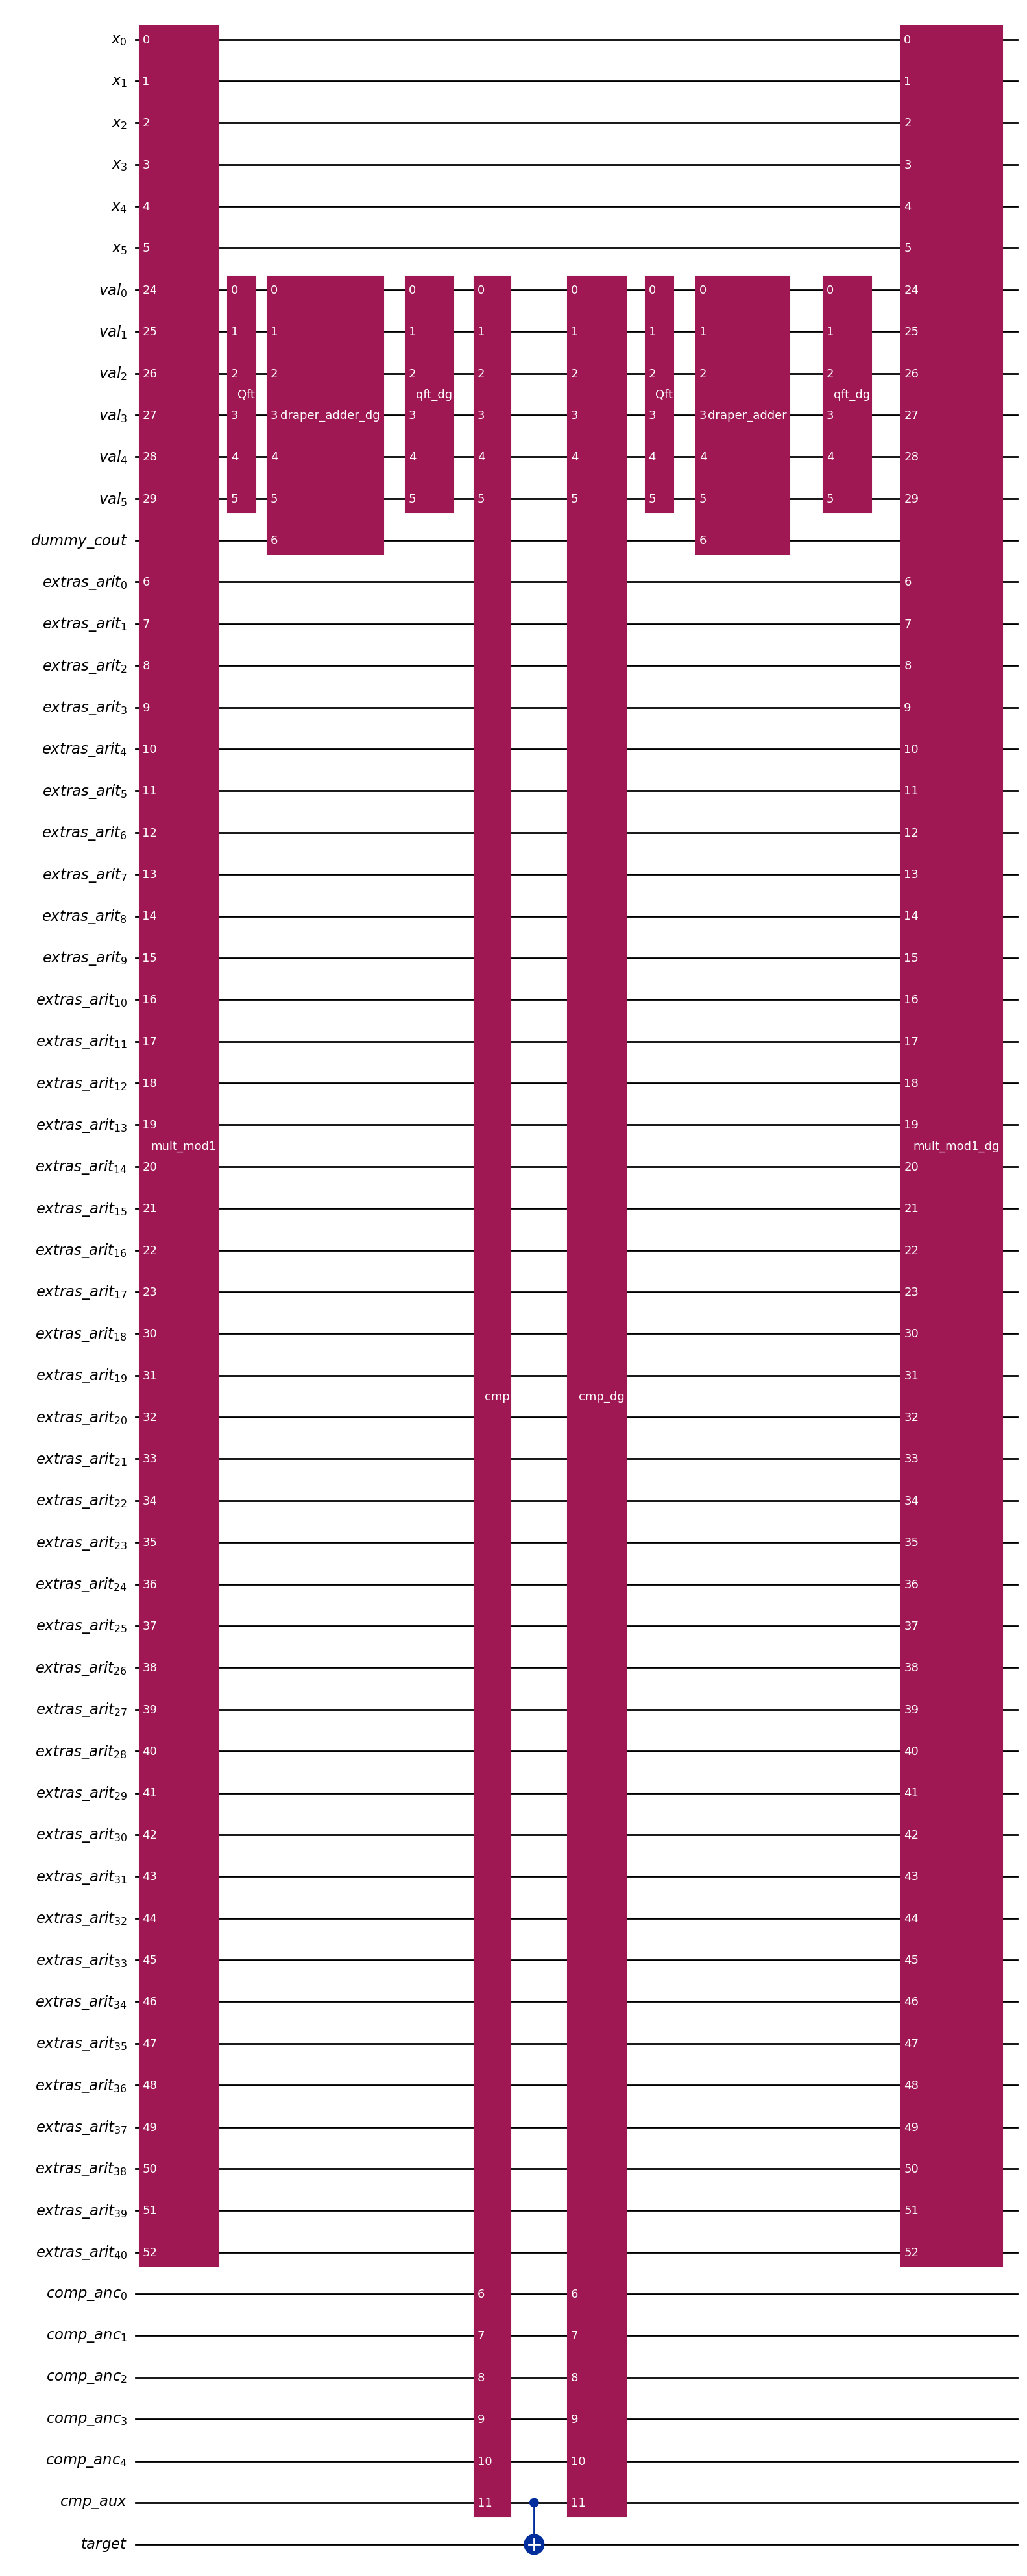

In [29]:
circuito_aritmetico_base = mult_mod1(6) 
oraculo = oraculo_otimizacao_draper(6, 60, circuito_aritmetico_base)

oraculo.draw("mpl")

In [30]:
n_bits = 6
tamanho_x = 4
alpha = 38
max_steps = 20

circuito_aritmetico_base = mult_mod1(n_bits) 
total_qubits_arit = circuito_aritmetico_base.num_qubits
num_ancilas_arit = total_qubits_arit - (2 * n_bits)
_comp_dummy = IntegerComparator(n_bits, 0)
num_ancilas_comp = _comp_dummy.num_qubits - n_bits - 1

limiar_atual = 60
backend = AerSimulator(method="matrix_product_state")
melhor_x = None

valores_ja_testados = set()
espaco_busca_total = 2**tamanho_x

print(f"--- Iniciando Otimização Quântica ---")
print(f"Objetivo: Encontrar x tal que (x² - {alpha}) mod 63 seja mínimo")
print(f"Limiar inicial: {limiar_atual}\n")

for passo in range(max_steps): 
    if len(valores_ja_testados) >= espaco_busca_total:
        print("Todos os valores possíveis do espaço de busca foram testados.")
        break

    qr_x = QuantumRegister(n_bits, 'x')
    qr_val = QuantumRegister(n_bits, 'val')
    qr_dummy = QuantumRegister(1, 'dummy_cout')
    qr_extras = QuantumRegister(num_ancilas_arit, 'extras_arit')
    qr_comp_anc = QuantumRegister(num_ancilas_comp, 'comp_anc')
    qr_cmp = QuantumRegister(1, 'cmp')
    qr_tgt = QuantumRegister(1, 'tgt')
    cr = ClassicalRegister(n_bits, 'medida')
    
    qc_main = QuantumCircuit(qr_x, qr_val, qr_dummy, qr_extras, qr_comp_anc, qr_cmp, qr_tgt, cr)
    
    for i in range(tamanho_x):
        qc_main.h(qr_x[i])
        
    qc_main.x(qr_tgt)
    qc_main.h(qr_tgt)
    
    oraculo = oraculo_otimizacao_draper(n_bits, limiar_atual, circuito_aritmetico_base)
    difusao = inversaoSobreMedia(tamanho_x) 
    
    todos_qubits = (list(qr_x) + list(qr_val) + list(qr_dummy) + list(qr_extras) + 
                    list(qr_comp_anc) + list(qr_cmp) + list(qr_tgt))

    for _ in range(3):
        qc_main.append(oraculo, todos_qubits)
        qc_main.append(difusao, qr_x[:tamanho_x])
        
    qc_main.measure(qr_x, cr)
    
    t_qc = transpile(qc_main, backend=backend, optimization_level=3)
    job = backend.run(t_qc, shots=1024)
    counts = job.result().get_counts()

    contagens_ordenadas = sorted(counts.items(), key=lambda item: item[1], reverse=True)
    
    x_medido = None
    
    for bitstring, frequencia in contagens_ordenadas:
        candidato = int(bitstring, 2)
        if candidato not in valores_ja_testados:
            x_medido = candidato
            break
    
    if x_medido is None:
        print(f"[Passo {passo+1}] Apenas valores repetidos foram medidos. Tentando novamente...")
        continue

    valores_ja_testados.add(x_medido)
    val_calc = (x_medido ** 2) % 63
    custo_atual = (val_calc - alpha) % (2**n_bits)
    
    if custo_atual < limiar_atual:
        print(f"[Passo {passo+1}] Sucesso! Encontrado f({x_medido}) com custo {custo_atual}. (Melhoria: {limiar_atual} -> {custo_atual})")
        limiar_atual = custo_atual
        melhor_x = x_medido
        
        if limiar_atual == 0:
            print("\n*** Mínimo Global Encontrado! ***")
            break
    else:
        print(f"[Passo {passo+1}] Testado f({x_medido}), mas obteve custo {custo_atual} que não melhorou (Limiar: {limiar_atual})")

print(f"\n\nResultado Final da Otimização:")
print(f"Melhor x candidato: {melhor_x}")
print(f"Valor da função de custo: {limiar_atual}")
print(f"Valores totais testados: {len(valores_ja_testados)} de {espaco_busca_total}")

if limiar_atual == 0:
    print("Conclusão: Solução EXATA encontrada.")
else:
    print("Conclusão: Solução aproximada.")

--- Iniciando Otimização Quântica ---
Objetivo: Encontrar x tal que (x² - 38) mod 63 seja mínimo
Limiar inicial: 60

[Passo 1] Testado f(10), mas obteve custo 63 que não melhorou (Limiar: 60)
[Passo 2] Sucesso! Encontrado f(2) com custo 30. (Melhoria: 60 -> 30)
[Passo 3] Sucesso! Encontrado f(1) com custo 27. (Melhoria: 30 -> 27)
[Passo 4] Testado f(3), mas obteve custo 35 que não melhorou (Limiar: 27)
[Passo 5] Sucesso! Encontrado f(7) com custo 11. (Melhoria: 27 -> 11)
[Passo 6] Testado f(5), mas obteve custo 51 que não melhorou (Limiar: 11)
[Passo 7] Testado f(12), mas obteve custo 44 que não melhorou (Limiar: 11)
[Passo 8] Sucesso! Encontrado f(13) com custo 5. (Melhoria: 11 -> 5)
[Passo 9] Testado f(14), mas obteve custo 33 que não melhorou (Limiar: 5)
[Passo 10] Testado f(0), mas obteve custo 26 que não melhorou (Limiar: 5)
[Passo 11] Testado f(9), mas obteve custo 44 que não melhorou (Limiar: 5)
[Passo 12] Testado f(4), mas obteve custo 42 que não melhorou (Limiar: 5)
[Passo 13]

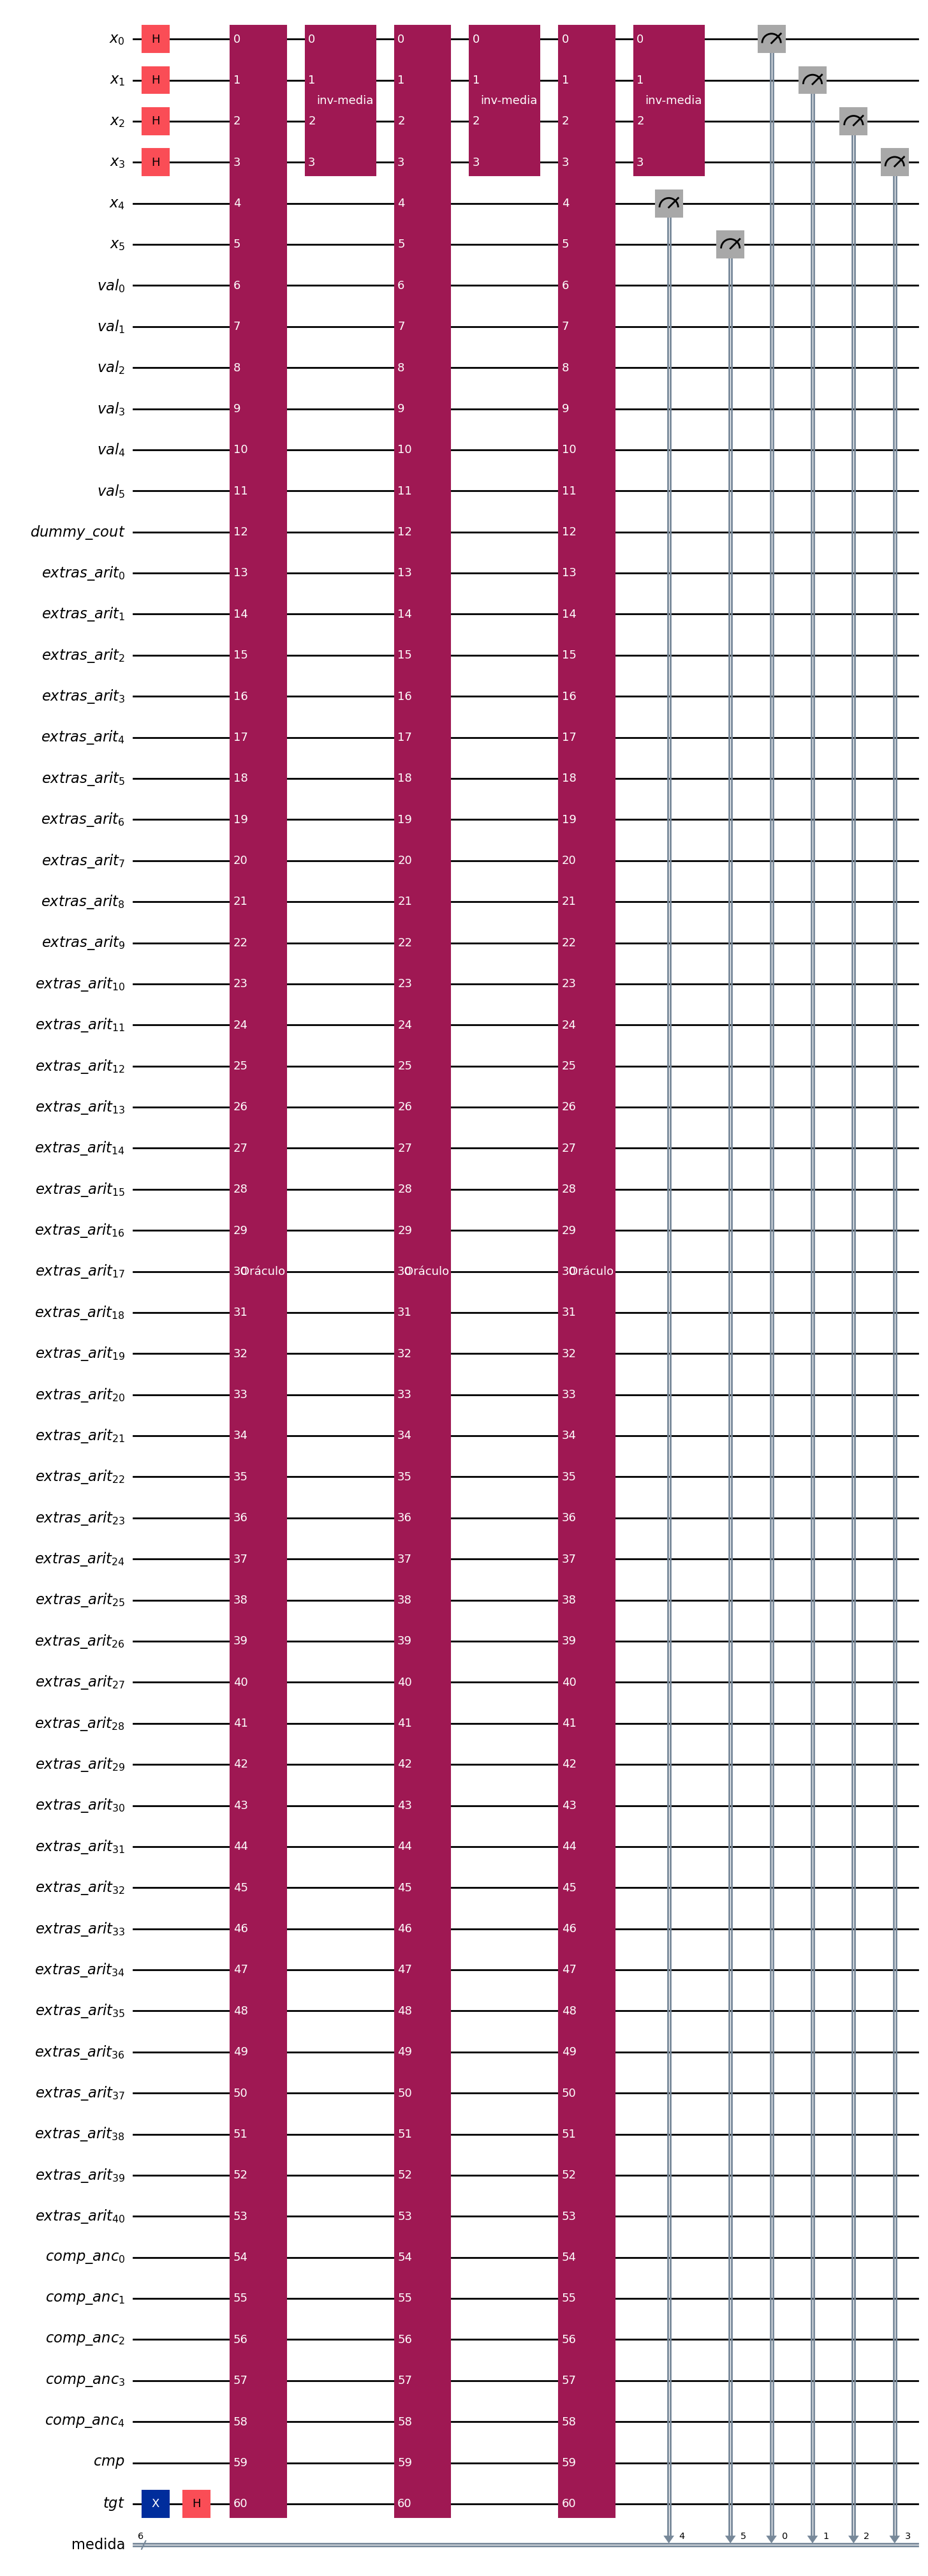

In [31]:
qc_main.draw("mpl")